In [7]:
from tqdm import tqdm

from torch import log2, arange
from torch import nn
from torch import optim
from torch.utils.data import random_split, DataLoader

from ptbo import NormalPerturbation
from ptbo import PerturbedLoss, NDCGLoss
from ptbo import RankingOracle
from ptbo import ndcg_score

from ptbo.datasets import salr

import matplotlib.pyplot as plt
import numpy as np

In [3]:
dataset = salr.Authorship()

n, m = map(len, dataset[0])

In [4]:
model = nn.Sequential(
    nn.Linear(n, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, m)
)

optimizer = optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9
)

perturb = NormalPerturbation()
oracle = RankingOracle(inputs=m)

weight = 1. / log2(2 + arange(m))

perturb_loss = PerturbedLoss(
    perturb=perturb,
    samples=100,
    oracle=oracle,
    loss=NDCGLoss(weight)
)

In [5]:
train_set, test_set = random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)

epochs = 10

In [6]:
running_losses = []
for epoch in tqdm(range(epochs), desc="Epoch", leave=True, position=0):
    model.train()

    running_loss = 0.0
    for X, y in tqdm(train_loader, desc="Batch", position=1):
        optimizer.zero_grad()
        theta = model(X)
        loss = perturb_loss(theta, y)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    running_loss /= len(train_loader)

    running_losses.append(running_loss)

Epoch: 100%|██████████| 10/10 [01:21<00:00,  8.17s/it]


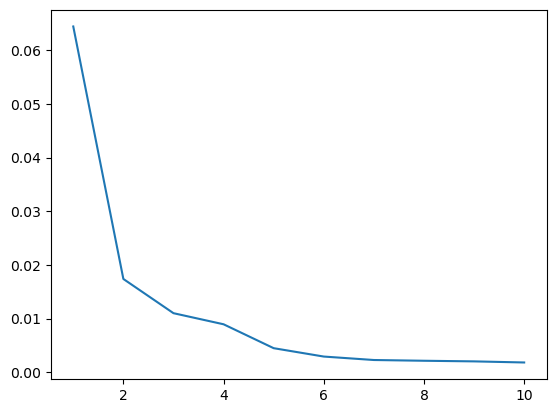

In [8]:
plt.plot(np.arange(1, 1+epochs), running_losses)
plt.show()

In [9]:
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

accuracy = 0.0
model.eval()
for X, y in test_loader:
    theta = model(X)
    perm = oracle.call(theta)
    running_accuracy = ndcg_score(perm, y, weight).mean().item()
    accuracy += running_accuracy

print(accuracy / len(test_loader))

0.99901223360073
